In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle

In [98]:
df = pd.read_excel('../data/NBAStats.xlsx').set_index('PLAYER')
df = df[df['GP'] >= 10]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
df = df.astype(float)

Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [99]:
dfPlayerCol = df.reset_index()
df

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST RATIO,OREB%,DREB%,...,FGM%UAST,DEF RTG,%DREB,STL%,%BLK,OPP PTSOFF TOV,OPP PTS2ND CHANCE,OPP PTSFB,OPP PTSPAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
Anthony Black,20.0,23.8,104.5,104.3,0.3,24.0,1.60,25.6,2.2,9.2,...,53.1,104.3,14.2,20.3,19.3,9.6,5.4,6.5,21.3,0.120
Bennedict Mathurin,22.0,33.1,113.2,112.2,1.0,8.0,0.92,10.2,3.9,14.4,...,38.2,112.2,21.6,13.8,10.0,11.6,9.2,8.9,34.0,0.088
Clint Capela,30.0,23.0,110.0,108.2,1.9,7.6,1.43,12.1,14.0,22.7,...,22.2,108.2,33.7,11.5,40.5,9.4,6.6,8.0,23.2,0.089
De'Aaron Fox,27.0,37.2,112.0,111.7,0.2,26.6,1.77,18.8,2.9,10.3,...,66.0,111.7,15.5,27.4,8.6,12.9,10.7,8.7,33.9,0.106
Jake LaRavia,23.0,22.8,117.0,106.8,10.2,18.6,2.12,27.7,6.5,12.4,...,21.1,106.8,19.1,20.7,17.6,10.2,7.3,7.0,23.5,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jazian Gortman,21.0,3.5,93.8,116.7,-22.8,14.3,1.50,15.0,2.4,5.9,...,50.0,116.7,8.3,25.0,25.0,0.6,1.0,2.0,4.6,0.005
Kobe Bufkin,21.0,12.4,95.3,103.3,-8.0,21.3,2.13,21.3,3.5,12.3,...,44.4,103.3,17.6,12.5,18.2,5.5,2.7,5.4,11.6,0.067
Robert Williams III,27.0,17.1,109.7,115.7,-6.0,10.9,1.50,17.9,10.6,19.0,...,25.8,115.7,32.1,29.6,42.4,8.9,4.9,6.8,16.8,0.029


In [100]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [101]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.406484761332997
Variance with 3 components: 0.5274298073307604
Variance with 4 components: 0.6117985121941549
Variance with 5 components: 0.6623322152745832
Variance with 6 components: 0.7102252271881239
Variance with 7 components: 0.7476735611900953
Variance with 8 components: 0.7773723376559796
Variance with 9 components: 0.8044698185961819
Variance with 10 components: 0.8287950691398381
Variance with 11 components: 0.8509379691329552
Variance with 12 components: 0.8713890724862573
Variance with 13 components: 0.8907398921319801
Variance with 14 components: 0.9070519700953472
Variance with 15 components: 0.9226264252335442
Variance with 16 components: 0.9370861360468653
Variance with 17 components: 0.948622440152431
Variance with 18 components: 0.959564868938927
Variance with 19 components: 0.9694218138961607
Variance with 20 components: 0.9752397254883781
Variance with 21 components: 0.979977945994416
Variance with 22 components: 0.9844106947195985
Vari

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

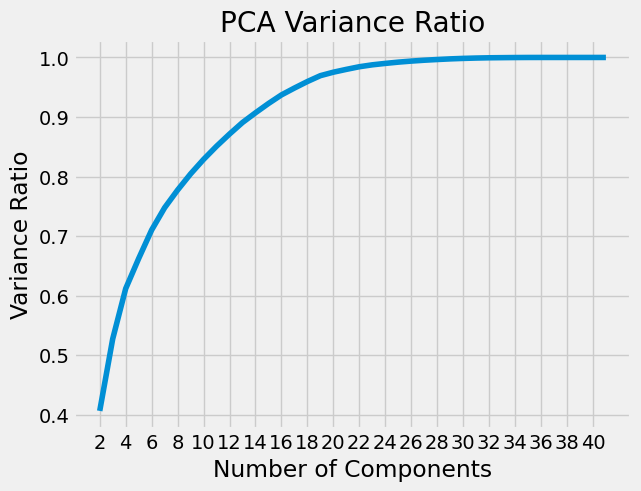

In [102]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [103]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.20945046e-01 8.43687049e-02 5.05337031e-02 4.78930119e-02
 3.74483340e-02 2.96987765e-02 2.70974809e-02 2.43252505e-02
 2.21429000e-02 2.04511034e-02 1.93508196e-02 1.63120780e-02
 1.55744551e-02 1.44597108e-02 1.15363041e-02 1.09424288e-02
 9.85694496e-03 5.81791159e-03 4.73822051e-03 4.43274873e-03
 3.20467318e-03 2.39184409e-03 2.14337158e-03 1.73693838e-03
 1.46722476e-03 1.19332958e-03 1.05303083e-03 8.14881171e-04
 5.96337261e-04 4.37505922e-04 2.19640202e-04 1.97452035e-04
 1.10812697e-04 2.17973324e-05 3.81657475e-07 7.73367426e-08
 7.27492599e-09 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

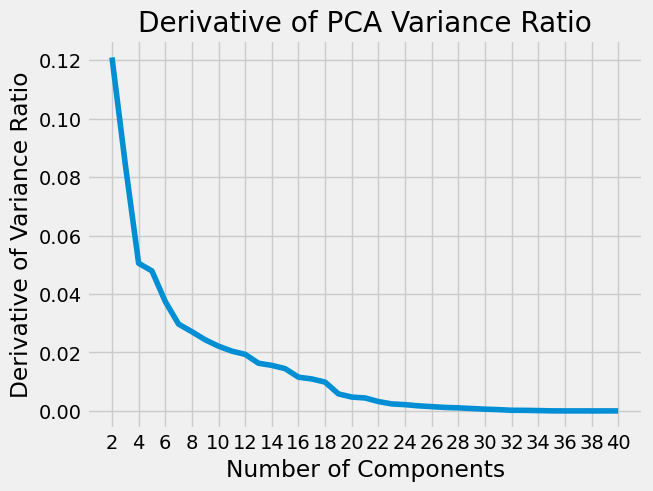

In [104]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [105]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.20685895 0.19962581 0.12094505 0.0843687  0.0505337  0.04789301
 0.03744833 0.02969878 0.02709748 0.02432525 0.0221429  0.0204511
 0.01935082 0.01631208 0.01557446 0.01445971]
0.9370861360468653


In [106]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 1)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.1991883540812445
Silhouette Score with 3 clusters: 0.1735528269716737
Silhouette Score with 4 clusters: 0.15935456279885907
Silhouette Score with 5 clusters: 0.11396539459157154
Silhouette Score with 6 clusters: 0.1275939797613123
Silhouette Score with 7 clusters: 0.10922217741619454
Silhouette Score with 8 clusters: 0.10879947724347443
Silhouette Score with 9 clusters: 0.11069223163445847
Silhouette Score with 10 clusters: 0.1113587788541317
Silhouette Score with 11 clusters: 0.10452325943121428
Silhouette Score with 12 clusters: 0.09826421018272984
Silhouette Score with 13 clusters: 0.0945860045893672
Silhouette Score with 14 clusters: 0.09413911664247418
Silhouette Score with 15 clusters: 0.09226455688097993
Silhouette Score with 16 clusters: 0.0839132262856144
Silhouette Score with 17 clusters: 0.07814725626363303
Silhouette Score with 18 clusters: 0.07909253632616824
Silhouette Score with 19 clusters: 0.0758358970111312
Silhouette Score with 20 

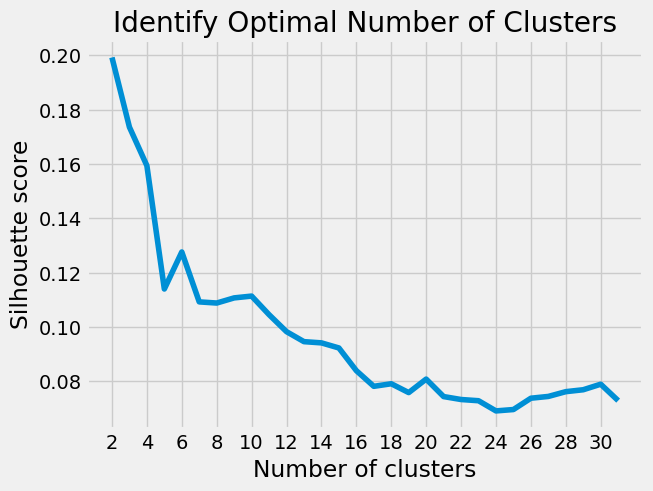

In [107]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [108]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = -0.03201193094558419
for n_cluseter = 4, improvement = -0.017179881105755745
for n_cluseter = 5, improvement = -0.05399323686143709
for n_cluseter = 6, improvement = 0.015381549531531591
for n_cluseter = 7, improvement = -0.02105877529374589
for n_cluseter = 8, improvement = -0.00047452929563740476
for n_cluseter = 9, improvement = 0.00212382549454726
for n_cluseter = 10, improvement = 0.000749512422339671
for n_cluseter = 11, improvement = -0.007692102572175674
for n_cluseter = 12, improvement = -0.006989627943333243
for n_cluseter = 13, improvement = -0.004079028064426726
for n_cluseter = 14, improvement = -0.0004935730496304913
for n_cluseter = 15, improvement = -0.0020693682616543807
for n_cluseter = 16, improvement = -0.009200181240769822
for n_cluseter = 17, improvement = -0.0062941308481101466
for n_cluseter = 18, improvement = 0.0010254132983363862
for n_cluseter = 19, improvement = -0.00353633719293045
for n_cluseter = 20, improvement = 0.0053

C:\conda_tmp\ipykernel_26904\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


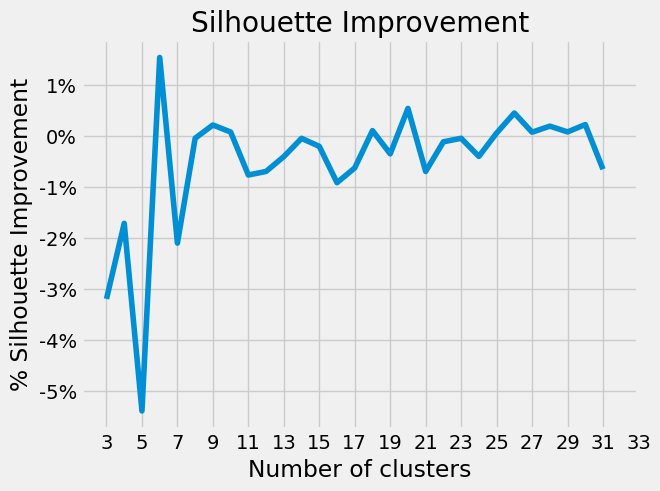

In [109]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [110]:
kmeans = KMeans(n_clusters = 6, random_state = 1)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [111]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,Anthony Black,5
1,Bennedict Mathurin,10
2,Clint Capela,12
3,De'Aaron Fox,11
4,Jake LaRavia,10


In [112]:
pd.DataFrame.to_excel(df_cluster, '../data/clusteredPlayers.xlsx')